In [ ]:
!pip install yfinance pandas_ta prophet scikit-learn matplotlib

In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=7677e1d0aa0f6dc255e5d75d96b002c4f730805c0c1f90e144482b2fc8b81d3e
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

# Companies ke tickers (e.g., Apple, Google, Microsoft)
tickers = ["AAPL", "GOOG", "MSFT"]

# Start aur end dates
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime.now()

# Data download karein
data = yf.download(tickers, start=start_date, end=end_date)

# Closing prices select karein
close_prices = data['Close']

# Missing values handle karein (forward fill ya interpolation)
close_prices = close_prices.fillna(method='ffill')

print(close_prices.head())


[*********************100%***********************]  3 of 3 completed

Ticker           AAPL       GOOG        MSFT
Date                                        
2020-01-02  72.716064  68.046204  153.323273
2020-01-03  72.009132  67.712273  151.414093
2020-01-06  72.582924  69.381882  151.805527
2020-01-07  72.241547  69.338577  150.421371
2020-01-08  73.403656  69.885002  152.817307



<ipython-input-2-40ce8d3cc314>:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices = close_prices.fillna(method='ffill')


In [1]:
!pip install numpy==1.24.4


In [2]:
import pandas_ta as ta
import numpy as np


In [3]:
import pandas_ta as ta
import numpy as np
import pandas as pd
import yfinance as yf

# Data download
close_prices = yf.download('AAPL', start='2020-01-01', end='2024-01-01')[['Close']]
close_prices.columns = ['AAPL']

# Indicators
close_prices['SMA_20'] = ta.sma(close_prices['AAPL'], length=20)
close_prices['EMA_20'] = ta.ema(close_prices['AAPL'], length=20)
close_prices['RSI'] = ta.rsi(close_prices['AAPL'], length=14)
bbands = ta.bbands(close_prices['AAPL'], length=20)
close_prices = pd.concat([close_prices, bbands], axis=1)

# Show result
print(close_prices.tail())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

                  AAPL      SMA_20      EMA_20        RSI  BBL_20_2.0  \
Date                                                                    
2023-12-22  192.444595  192.512675  192.165105  54.672814  186.871918   
2023-12-26  191.897873  192.674703  192.139655  53.090039  187.306655   
2023-12-27  191.997269  192.811383  192.126094  53.354428  187.662988   
2023-12-28  192.424698  193.020627  192.154532  54.540961  188.310965   
2023-12-29  191.380966  193.148857  192.080860  51.121318  188.776482   

            BBM_20_2.0  BBU_20_2.0  BBB_20_2.0  BBP_20_2.0  
Date                                                        
2023-12-22  192.512675  198.153432    5.860141    0.493965  
2023-12-26  192.674703  198.042751    5.572136    0.427643  
2023-12-27  192.811383  197.959778    5.340344    0.420935  
2023-12-28  193.020627  197.730288    4.879957    0.436733  
2023-12-29  193.148857  197.521233    4.527467    0.297834  


In [4]:
from sklearn.ensemble import IsolationForest

# Feature selection (e.g., RSI, Bollinger Bands)
features = close_prices[['RSI', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0']].dropna()

# Isolation Forest model train karein
model = IsolationForest(contamination=0.05) # 5% anomalies expect karein
model.fit(features)

# Anomalies predict karein
anomalies = model.predict(features)

# Anomalies ko DataFrame mein add karein
close_prices = close_prices.loc[features.index] # Index matching
close_prices['Anomaly'] = anomalies

print(close_prices[close_prices['Anomaly'] == -1]) # -1 indicates anomaly

                  AAPL      SMA_20      EMA_20        RSI  BBL_20_2.0  \
Date                                                                    
2020-02-25   69.910965   76.977584   76.106676  30.807955   72.334282   
2020-02-27   66.377556   76.075546   74.741786  27.345478   69.190994   
2020-02-28   66.338753   75.471966   73.941497  27.290459   67.483813   
2020-03-12   60.240215   71.585096   70.329965  33.550777   61.412836   
2020-03-16   58.779293   70.012051   68.982387  36.847028   59.587212   
2020-03-18   59.861626   68.275804   67.457268  39.022289   57.946562   
2020-03-19   59.402969   67.359447   66.690192  38.591317   57.299474   
2020-03-20   55.631748   66.342500   65.637007  35.153485   55.866649   
2020-03-23   54.449886   65.446893   64.571567  34.127436   54.151987   
2020-03-24   59.912601   64.946975   64.127856  42.483784   53.601697   
2020-03-25   59.582546   64.375102   63.694969  42.135986   53.159655   
2020-03-26   62.717979   64.192123   63.601923  46.

In [5]:
from prophet import Prophet

# Data ko Prophet ke format mein convert karein
df_prophet = close_prices[['AAPL']].reset_index().rename(columns={'Date': 'ds', 'AAPL': 'y'})

# Prophet model train karein
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Future dates predict karein
future = model_prophet.make_future_dataframe(periods=30) # 30 days forecast
forecast = model_prophet.predict(future)

# Forecast aur actual values compare karein
# Deviations identify karein

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp13dngfs/p_iodnbg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp13dngfs/tguinq9x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89854', 'data', 'file=/tmp/tmpp13dngfs/p_iodnbg.json', 'init=/tmp/tmpp13dngfs/tguinq9x.json', 'output', 'file=/tmp/tmpp13dngfs/prophet_model7goifj0u/prophet_model-20250416070216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:02:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:02:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


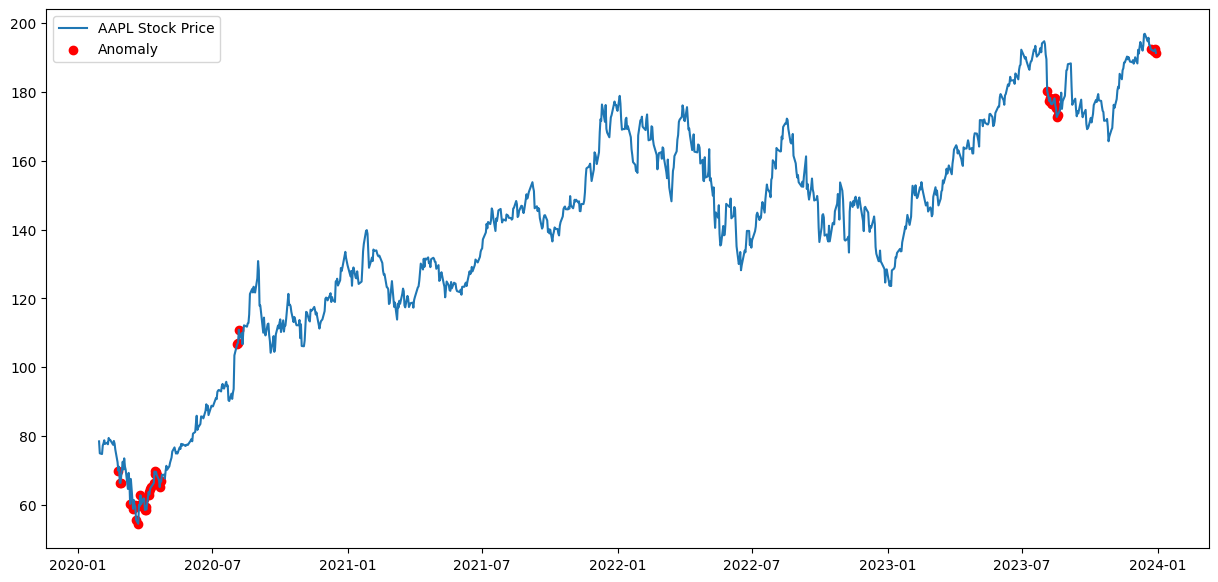

In [6]:
import matplotlib.pyplot as plt

# Stock price aur anomalies plot karein
plt.figure(figsize=(15, 7))
plt.plot(close_prices['AAPL'], label='AAPL Stock Price')
plt.scatter(close_prices[close_prices['Anomaly'] == -1].index,
            close_prices[close_prices['Anomaly'] == -1]['AAPL'],
            color='red', label='Anomaly')
plt.legend()
plt.show()